In [32]:
import joblib
import pandas as pd
import pandas
import numpy as np
import sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from flaml import AutoML

claims_data = pd.read_excel('claims_data.xlsx')

In [33]:
claims_data

,Claim Number,date_of_loss,Notifier,Loss_code,Loss_description,Notification_period,Inception_to_loss,Location_of_incident,Weather_conditions,Vehicle_mobile,...,TP_region_northw,TP_region_outerldn,TP_region_scotland,TP_region_southe,TP_region_southw,TP_region_wales,TP_region_westmid,TP_region_yorkshire,Incurred,Capped Incurred
0,1,2003-04-15,PH,LD003,Head on collision,22,13,Main Road,NORMAL,Y,...,1,0,0,0,0,0,0,0,0.000000,0.000000
1,2,2003-04-20,CNF,LD003,Head on collision,1,9,Main Road,WET,Y,...,0,0,0,1,0,0,0,0,2801.308013,2801.308013
2,3,2003-04-24,CNF,LD003,Head on collision,5,17,Main Road,WET,Y,...,1,0,0,0,0,0,0,0,1220.870390,1220.870390
3,4,2003-05-13,CNF,LD003,Head on collision,1,23,Main Road,N/K,Y,...,0,0,0,0,0,0,1,0,3529.868026,3529.868026
4,5,2003-06-11,CNF,LD003,Head on collision,1,48,Other,N/K,N,...,0,0,0,0,0,0,0,0,3155.987923,3155.987923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7686,7687,2015-06-30,Other,LD003,Head on collision,1,83,Main Road,NORMAL,N,...,1,0,0,0,0,0,0,0,702.814301,702.814301
7687,7688,2015-06-30,Other,LD003,Head on collision,0,25,Minor Road,NaN,Y,...,0,0,0,0,0,0,0,2,42980.618893,42980.618893
7688,7689,2015-06-30,Other,LD003,Head on collision,0,60,Minor Road,NORMAL,Y,...,0,0,0,1,0,0,0,0,5174.800838,5174.800838
7689,7690,2015-06-30,Other,LD003,Head on collision,1,253,Minor Road,NORMAL,N,...,0,0,0,0,0,0,0,0,30072.417085,30072.417085


In [34]:
bins = [-1, 0, 50000]
labels = [0, 1]

# Categorize the 'loss' column
claims_data['Incurred_cat'] = pd.cut(claims_data['Incurred'], bins=bins, labels=labels)
claims_data = claims_data[~claims_data['Incurred_cat'].isna()]
#change "incurred_cat" to int
claims_data["Incurred_cat"] = claims_data["Incurred_cat"].astype(int)

C:\Users\colin\AppData\Local\Temp\ipykernel_121276\616756558.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claims_data["Incurred_cat"] = claims_data["Incurred_cat"].astype(int)


In [35]:
claims_data.loc[claims_data["Notification_period"] < 0, "Notification_period"] = np.nan
claims_data.loc[claims_data["PH_considered_TP_at_fault"] == "#", "PH_considered_TP_at_fault"] = np.nan
claims_data.drop(columns=["Claim Number", "date_of_loss", "Loss_code", "Loss_description", "Capped Incurred"],
                 inplace=True)

claims_data = claims_data[~claims_data['Incurred_cat'].isna()] # removed instances where Incurred_cat is NaN because loss was negative. Likely a mistake in the data or sued for expenses. Not enough cases to validate keeping it in. 

def one_hot_encode_categorical_columns(df: pd.DataFrame) -> (pd.DataFrame, OneHotEncoder):
    """
    One-hot encodes all categorical columns in the DataFrame using OneHotEncoder.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing columns to be encoded.
    
    Returns:
    pd.DataFrame: The DataFrame with categorical columns one-hot encoded.
    """
    
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    ohe = OneHotEncoder(sparse_output=False, drop='first')
    encoded_df = pd.DataFrame(ohe.fit_transform(df[categorical_columns]))

    encoded_df.columns = ohe.get_feature_names_out(categorical_columns)
    df = df.drop(columns=categorical_columns).reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)

    return pd.concat([df, encoded_df], axis=1), ohe


encoded_claims, encoder = one_hot_encode_categorical_columns(claims_data)
train, test = train_test_split(encoded_claims, test_size=0.10, random_state=32, shuffle=True)


C:\Users\colin\AppData\Local\Temp\ipykernel_121276\3344046873.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claims_data.drop(columns=["Claim Number", "date_of_loss", "Loss_code", "Loss_description", "Capped Incurred"],


In [36]:
train.dtypes

Notification_period                    float64
Inception_to_loss                        int64
Time_hour                                int64
Vechile_registration_present             int64
Incident_details_present                 int64
Injury_details_present                   int64
TP_type_insd_pass_back                   int64
TP_type_insd_pass_front                  int64
TP_type_driver                           int64
TP_type_pass_back                        int64
TP_type_pass_front                       int64
TP_type_bike                             int64
TP_type_cyclist                          int64
TP_type_pass_multi                       int64
TP_type_pedestrian                       int64
TP_type_other                            int64
TP_type_nk                               int64
TP_injury_whiplash                       int64
TP_injury_traumatic                      int64
TP_injury_fatality                       int64
TP_injury_unclear                        int64
TP_injury_nk 

In [37]:
dtypes_dict = claims_data.dtypes.astype(str).to_dict() 
dtypes_dict.pop("Incurred")
dtypes_dict.pop("Incurred_cat")
# Ensuring the data types are converted to string
import json
# Save the dictionary to a JSON file
with open('dtypes_dict.json', 'w') as json_file:
    json.dump(dtypes_dict, json_file)

In [38]:
with open('dtypes_dict.json', 'r') as json_file:
    loaded_dtypes_dict = json.load(json_file)
loaded_dtypes_dict

{'Notifier': 'object',
 'Notification_period': 'float64',
 'Inception_to_loss': 'int64',
 'Location_of_incident': 'object',
 'Weather_conditions': 'object',
 'Vehicle_mobile': 'object',
 'Time_hour': 'int64',
 'Main_driver': 'object',
 'PH_considered_TP_at_fault': 'object',
 'Vechile_registration_present': 'int64',
 'Incident_details_present': 'int64',
 'Injury_details_present': 'int64',
 'TP_type_insd_pass_back': 'int64',
 'TP_type_insd_pass_front': 'int64',
 'TP_type_driver': 'int64',
 'TP_type_pass_back': 'int64',
 'TP_type_pass_front': 'int64',
 'TP_type_bike': 'int64',
 'TP_type_cyclist': 'int64',
 'TP_type_pass_multi': 'int64',
 'TP_type_pedestrian': 'int64',
 'TP_type_other': 'int64',
 'TP_type_nk': 'int64',
 'TP_injury_whiplash': 'int64',
 'TP_injury_traumatic': 'int64',
 'TP_injury_fatality': 'int64',
 'TP_injury_unclear': 'int64',
 'TP_injury_nk': 'int64',
 'TP_region_eastang': 'int64',
 'TP_region_eastmid': 'int64',
 'TP_region_london': 'int64',
 'TP_region_north': 'int64',


In [39]:
claims_data.loc[0].to_dict()

{'Notifier': 'PH',
 'Notification_period': 22.0,
 'Inception_to_loss': 13,
 'Location_of_incident': 'Main Road',
 'Weather_conditions': 'NORMAL',
 'Vehicle_mobile': 'Y',
 'Time_hour': 10,
 'Main_driver': 'Other',
 'PH_considered_TP_at_fault': 'n/k',
 'Vechile_registration_present': 1,
 'Incident_details_present': 0,
 'Injury_details_present': 0,
 'TP_type_insd_pass_back': 0,
 'TP_type_insd_pass_front': 0,
 'TP_type_driver': 0,
 'TP_type_pass_back': 0,
 'TP_type_pass_front': 0,
 'TP_type_bike': 0,
 'TP_type_cyclist': 0,
 'TP_type_pass_multi': 0,
 'TP_type_pedestrian': 0,
 'TP_type_other': 0,
 'TP_type_nk': 1,
 'TP_injury_whiplash': 0,
 'TP_injury_traumatic': 0,
 'TP_injury_fatality': 0,
 'TP_injury_unclear': 1,
 'TP_injury_nk': 0,
 'TP_region_eastang': 0,
 'TP_region_eastmid': 0,
 'TP_region_london': 0,
 'TP_region_north': 0,
 'TP_region_northw': 1,
 'TP_region_outerldn': 0,
 'TP_region_scotland': 0,
 'TP_region_southe': 0,
 'TP_region_southw': 0,
 'TP_region_wales': 0,
 'TP_region_west

In [40]:
from random import uniform, randint
from collections import namedtuple

DataSet = namedtuple('DataSet', ['features', 'target'])
train_set = DataSet(features=train.drop(columns=["Incurred_cat",'Incurred']), target=train["Incurred_cat"])
test_set = DataSet(features=test.drop(columns=["Incurred_cat",'Incurred']), target=test["Incurred_cat"])
train_d_matrix = xgb.DMatrix(train_set.features, label=train_set.target, enable_categorical=False)
test_d_matrix = xgb.DMatrix(test_set.features, label=test_set.target, enable_categorical=False)



# automl_classification = AutoML()
# 
# automl_clas_settings = {
#     "time_budget": 600,  # total running time in seconds
#     "metric": 'macro_f1',  # metric to optimize
#     "task": 'classification',  # task type
#     
#     "n_splits": 5,  # number of splits in time cross-validation
#     "sample": True,  # enable sampling
#     "estimator_list": ['xgboost'],  # list of ML algorithms to use
#     "log_file_name": 'flaml.log',  # log file
#     "eval_method": "cv",  # cross-validation
#     "max_iter": 200,  # maximum number of iterations
#     "early_stop": True,  # enable early stopping
#     "n_jobs": 4,  # number of parallel jobs
#     "ensemble": True,  # use ensemble methods
#     "custom_hp": {
#         'xgboost': {
#             'n_estimators': {'domain': randint(50, 500), 'init_value': 100},
#             'max_depth': {'domain': randint(3, 10), 'init_value': 6},
#             'subsample': {'domain': uniform(0.6, 1.0), 'init_value': 0.8},
#             'learning_rate': {'domain': uniform(0.1, 0.3), 'init_value': 0.1},
#         },
#     }
# }
# 
# automl_classification.fit(X_train=train_set.features, y_train=train_set.target, **automl_clas_settings)
# best_params = automl_classification.best_config

best_params = {'max_leaves': 27, 'min_child_weight': 5.934123526951441, 'colsample_bylevel': 0.9237064316343299,
               'colsample_bytree': 0.938515547014156, 'reg_alpha': 0.21802096600346335,
               'reg_lambda': 0.02190127779518735, 'n_estimators': 233, 'learning_rate': 0.15217498060598927,
               'subsample': 0.8633042594355675, 'max_depth': 9, "objective": "binary:logistic"}
best_clas_model = xgb.train(best_params, train_d_matrix, num_boost_round=100)

C:\Users\colin\PycharmProjects\claim_cost\claim_cost_env\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:34:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [41]:
#save encoder
joblib.dump(encoder, 'encoder.joblib')

['encoder.joblib']

In [42]:
test_d_matrix

In [43]:
best_clas_model.predict(test_d_matrix)

array([0.9596653 , 0.9943685 , 0.9031068 , 0.5893384 , 0.6157638 ,
       0.6148881 , 0.8473933 , 0.48380142, 0.4886671 , 0.6509784 ,
       0.8639356 , 0.99047965, 0.3541687 , 0.93905914, 0.980477  ,
       0.94361943, 0.9534055 , 0.81272626, 0.946252  , 0.9926403 ,
       0.9360728 , 0.90848374, 0.9393737 , 0.59637856, 0.82717955,
       0.86567694, 0.83310664, 0.65211177, 0.96229476, 0.78687716,
       0.7412516 , 0.48083743, 0.88681424, 0.84324795, 0.94803303,
       0.9562777 , 0.6597645 , 0.67275506, 0.5144278 , 0.5113815 ,
       0.9246787 , 0.5835569 , 0.94241285, 0.9104373 , 0.9612374 ,
       0.974192  , 0.8449184 , 0.43713543, 0.5881179 , 0.62024665,
       0.19188125, 0.67743695, 0.32499778, 0.9698149 , 0.5765947 ,
       0.7527137 , 0.9768063 , 0.95528173, 0.71326894, 0.9917538 ,
       0.3558217 , 0.5492829 , 0.9878726 , 0.9430328 , 0.8034626 ,
       0.85889935, 0.9822145 , 0.7019164 , 0.910419  , 0.97706044,
       0.88313055, 0.4262291 , 0.97323686, 0.6011896 , 0.85610

In [44]:
encoder

OneHotEncoder(drop='first', sparse_output=False)

In [45]:
best_clas_model.save_model("no_loss_proba_model.json")

Accuracy: 0.7503
Precision: 0.7810
Recall: 0.9222
F1 Score: 0.8458
ROC AUC Score: 0.7356
Confusion Matrix:
[[ 49 143]
 [ 43 510]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.26      0.35       192
           1       0.78      0.92      0.85       553

    accuracy                           0.75       745
   macro avg       0.66      0.59      0.60       745
weighted avg       0.72      0.75      0.72       745



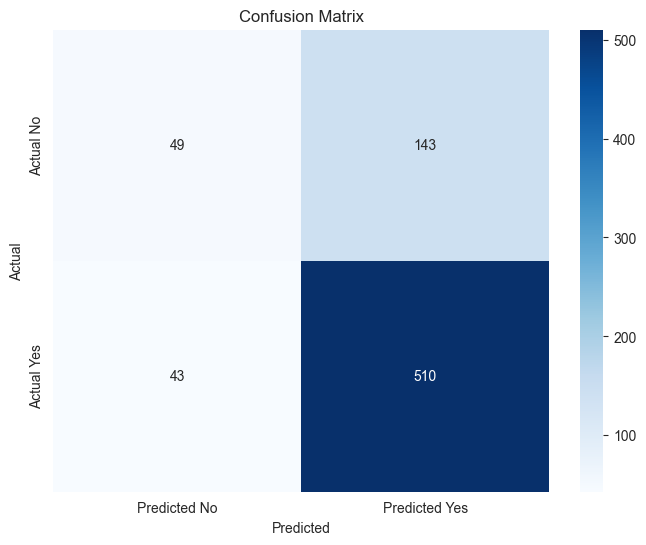

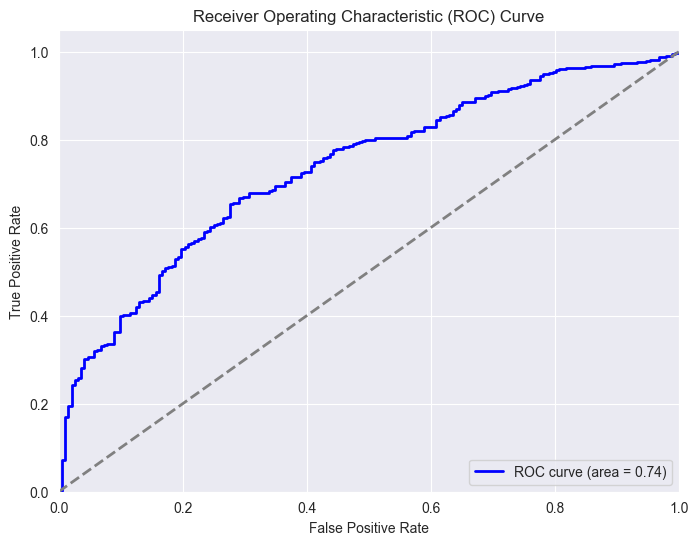

In [46]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
test_predictions = (best_clas_model.predict(test_d_matrix) > 0.5).astype(int)
test_proba = best_clas_model.predict(test_d_matrix)

# Accuracy
accuracy = accuracy_score(test_set.target, test_predictions)
print(f'Accuracy: {accuracy:.4f}')

# Precision, Recall, F1 Score
precision = precision_score(test_set.target, test_predictions)
recall = recall_score(test_set.target, test_predictions)
f1 = f1_score(test_set.target, test_predictions)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# ROC-AUC Score
roc_auc = roc_auc_score(test_set.target, test_proba)
print(f'ROC AUC Score: {roc_auc:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(test_set.target, test_predictions)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report
class_report = classification_report(test_set.target, test_predictions)
print('Classification Report:')
print(class_report)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(test_set.target, test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# If feature importance is applicable
if hasattr(best_clas_model, 'feature_importances_'):
    feature_importance = best_clas_model.feature_importances_
    feature_names = test_set.features.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Feature Importance')
    plt.show()


                                Feature  Importance
1                     Inception_to_loss       681.0
2                             Time_hour       328.0
0                   Notification_period       297.0
13                         TP_injury_nk        92.0
32      Location_of_incident_Minor Road        67.0
28                          Notifier_PH        64.0
12                    TP_injury_unclear        63.0
36            Weather_conditions_NORMAL        61.0
31       Location_of_incident_Main Road        61.0
4                Injury_details_present        55.0
6                        TP_type_driver        53.0
40                     Vehicle_mobile_Y        52.0
27                       Notifier_Other        52.0
45        PH_considered_TP_at_fault_n/k        49.0
43                        Main_driver_Y        48.0
10                   TP_injury_whiplash        48.0
9                            TP_type_nk        41.0
42                    Main_driver_Other        35.0
3           

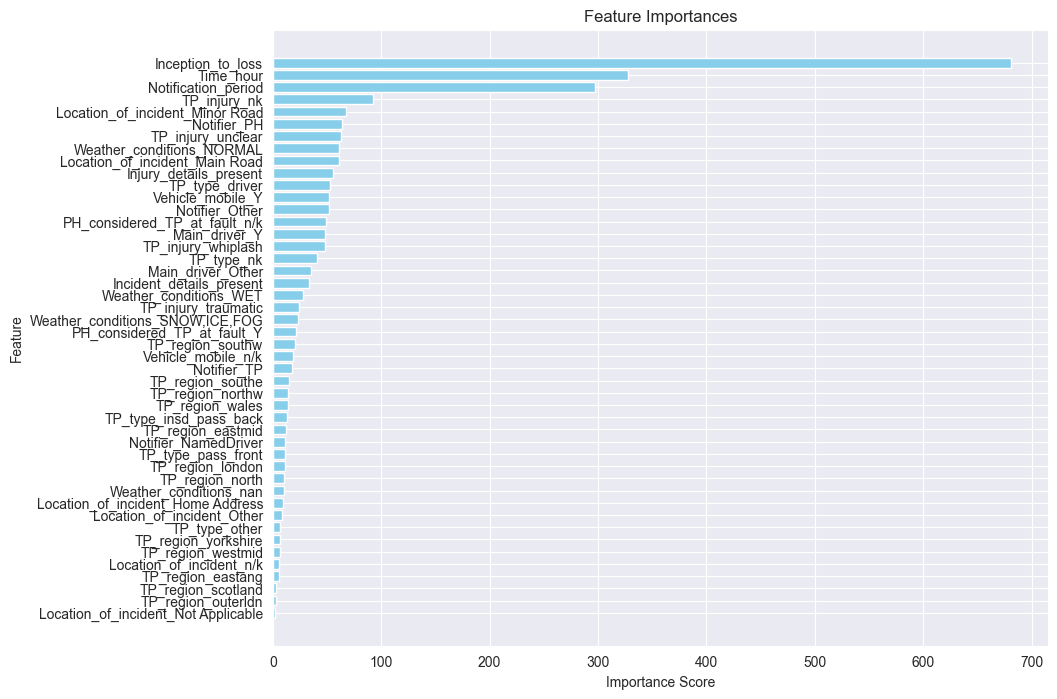

In [47]:
feature_importances = best_clas_model.get_score()

importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(importance_df)

import matplotlib.pyplot as plt

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [48]:
train["loss_proba"] = best_clas_model.predict(train_d_matrix)
test["loss_proba"] = best_clas_model.predict(test_d_matrix)

In [49]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from flaml import AutoML

DataSet = namedtuple('DataSet', ['features', 'target'])
train_set = DataSet(features=train.drop(columns=["Incurred_cat",'Incurred']), target=train["Incurred"])
test_set = DataSet(features=test.drop(columns=["Incurred_cat",'Incurred']), target=test["Incurred"])
train_d_matrix = xgb.DMatrix(train_set.features, label=train_set.target, enable_categorical=False)
test_d_matrix = xgb.DMatrix(test_set.features, label=test_set.target, enable_categorical=False)

# automl_regression = AutoML()
# 
# automl_reg_settings = {
#     "time_budget": 600,  # total running time in seconds
#     "metric": 'mse',  # metric to optimize
#     "task": 'regression',  # task type
#     "n_splits": 5,  # number of splits in time cross-validation
#     "sample": True,  # enable sampling
#     "estimator_list": ['xgboost'],  # list of ML algorithms to use
#     "log_file_name": 'flaml.log',  # log file
#     "eval_method": "cv",  # cross-validation
#     "max_iter": 200,  # maximum number of iterations
#     "early_stop": True,  # enable early stopping
#     "n_jobs": 4,  # number of parallel jobs
#     "ensemble": True,  # use ensemble methods
#     "custom_hp": {
#         'xgboost': {
#             'n_estimators': {'domain': randint(50, 500), 'init_value': 100},
#             'max_depth': {'domain': randint(3, 10), 'init_value': 6},
#             'subsample': {'domain': uniform(0.6, 1.0), 'init_value': 0.8},
#             'learning_rate': {'domain': uniform(0.1, 0.3), 'init_value': 0.1},
#         },
#     }
# }
# 
# automl_regression.fit(X_train=train_set.features, y_train=train_set.target, **automl_reg_settings)
# 
# print('Best hyperparameters:', automl_regression.best_config)

# best_params = automl_regression.best_config
best_reg_params = {'max_leaves': 4, 'min_child_weight': 9.013831375302424, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.002493586883585935, 'reg_lambda': 23.21315601383053, 'n_estimators': 142, 'learning_rate': 0.2172339422320672, 'subsample': 0.7982024057095053, 'max_depth': 7}
best_model = xgb.train(best_reg_params, train_d_matrix, num_boost_round=100)

test_predictions = best_model.predict(test_d_matrix)
mae = mean_absolute_error(test_set.target, test_predictions)
print(f'Test MAE: {mae}')

Test MAE: 3887.892279286287


C:\Users\colin\PycharmProjects\claim_cost\claim_cost_env\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:34:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


                            Feature  Importance
39                       loss_proba        70.0
12               TP_injury_whiplash        18.0
0               Notification_period        17.0
2                         Time_hour        16.0
15                     TP_injury_nk        15.0
13              TP_injury_traumatic        15.0
10                    TP_type_other        13.0
6                    TP_type_driver        11.0
14                TP_injury_unclear        10.0
26              TP_region_yorkshire         9.0
19                 TP_region_northw         8.0
21               TP_region_scotland         8.0
7                 TP_type_pass_back         7.0
17                TP_region_eastmid         7.0
9                      TP_type_bike         6.0
1                 Inception_to_loss         6.0
22                 TP_region_southe         6.0
33                 Vehicle_mobile_Y         5.0
5            TP_type_insd_pass_back         5.0
27                   Notifier_Other     

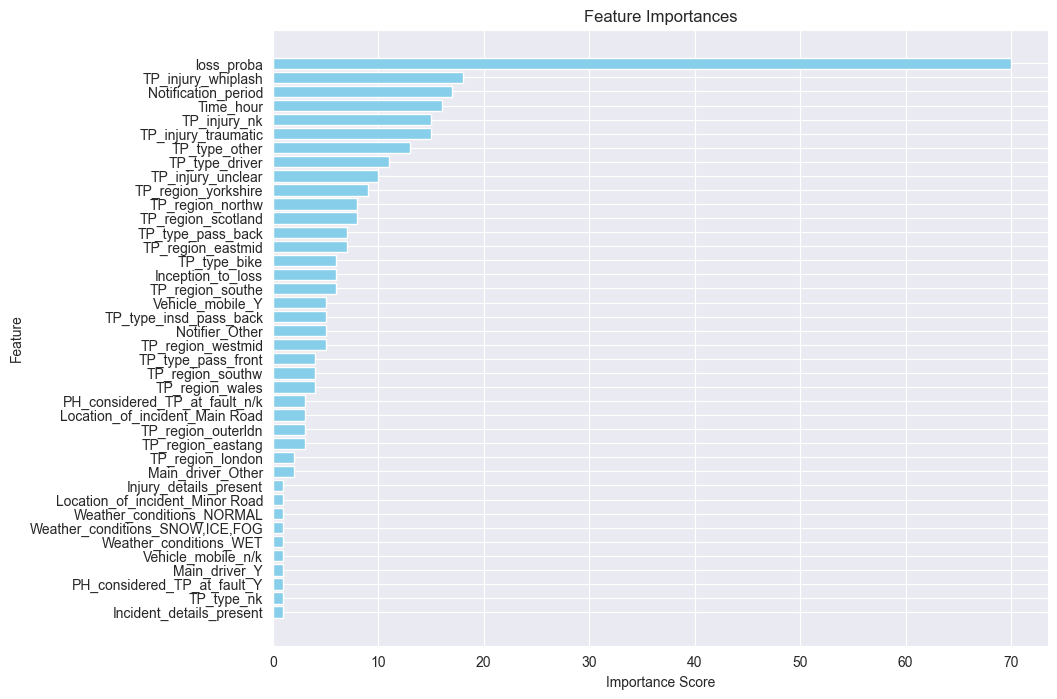

In [50]:
feature_importances = best_model.get_score()

importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(importance_df)

import matplotlib.pyplot as plt

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [51]:
best_model.save_model("claims_model.json")

In [52]:
mae = mean_absolute_error(test_set.target, test_predictions)

In [53]:
mae

3887.892279286287

In [55]:
rounded_predictions = np.round(test_predictions, 2)

In [75]:
modified_predictions = np.where(rounded_predictions < 2000, 0, rounded_predictions)

In [76]:
mae2 = mean_absolute_error(test_set.target, modified_predictions)

In [77]:
mae2

3793.7175331725844

In [79]:
# Print the values row by row
for target, prediction in zip(test_set.target, modified_predictions):
    print(f"Actual: {target}, Predicted: {prediction}")


Actual: 8363.603635200001, Predicted: 13796.2099609375
Actual: 19161.3697936, Predicted: 24185.599609375
Actual: 5724.8427024, Predicted: 13778.0
Actual: 172.4089968, Predicted: 0.0
Actual: 0.0, Predicted: 0.0
Actual: 0.0, Predicted: 0.0
Actual: 375.43648160000004, Predicted: 2519.419921875
Actual: 2640.2591296, Predicted: 0.0
Actual: 1188.4191568, Predicted: 0.0
Actual: 3542.8281552000003, Predicted: 0.0
Actual: 5607.5324384000005, Predicted: 3719.780029296875
Actual: 19470.667432000002, Predicted: 13810.3203125
Actual: 25.6584384, Predicted: 0.0
Actual: 11901.471740800001, Predicted: 4487.31005859375
Actual: 4052.9423472, Predicted: 9395.6103515625
Actual: 12198.2456176, Predicted: 9994.580078125
Actual: 846.2920992000002, Predicted: 10262.6796875
Actual: 9368.311864, Predicted: 3645.989990234375
Actual: 4186.6745936, Predicted: 2688.719970703125
Actual: 31194.9883104, Predicted: 28654.640625
Actual: 0.0, Predicted: 2865.89990234375
Actual: 0.0, Predicted: 5578.85009765625
Actual: 0.